# Set Up

## Imports

In [49]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Patch
import seaborn as sns
from time import time
from CBFV import composition
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, normalize, OrdinalEncoder
from sklearn.model_selection import learning_curve, RandomizedSearchCV, cross_validate, GroupKFold, KFold
import shap
from scipy.stats import gaussian_kde
import statsmodels.api as sm
import random

In [45]:
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

## Seed and Paths

In [46]:
RNG_SEED = 8
np.random.seed(RNG_SEED)
curr_dir = os.getcwd()
DATA_PATH = os.path.join(os.path.dirname(curr_dir), 'Data')
MODELS_PATH = os.path.join(os.path.dirname(curr_dir), 'Models')
WEIGHTS_PATH = os.path.join(os.path.dirname(curr_dir), 'Weights')
ASSETS_PATH = os.path.join(os.path.dirname(curr_dir), 'Assets')
RESULTS_PATH = os.path.join(os.path.dirname(curr_dir), 'Results')

# Data

## Collection

In [4]:
df_train = pd.read_csv(DATA_PATH + "/intermetallics_train7.csv")
df_val = pd.read_csv(DATA_PATH + "/intermetallics_val7.csv")
df_test = pd.read_csv(DATA_PATH + "/intermetallics_test7.csv")

## Preprocessing

In [5]:
# remove categorical data and individual atomic fractions added with matminer (except B)
df_train.drop(columns=['composition', 'material_id',
              'structure'], axis=1, inplace=True)

df_val.drop(columns=['composition', 'material_id',
            'structure'], axis=1, inplace=True)

df_test.drop(columns=['composition', 'material_id',
             'structure'], axis=1, inplace=True)

# Gonna train  total_magnetization_ per formula unit so need to remove all other magnetic fields as to not overtrain the data
df_train.drop(['total_magnetization',
              'total_magnetization_normalized_vol'], axis=1, inplace=True)
df_val.drop(['total_magnetization',
            'total_magnetization_normalized_vol'], axis=1, inplace=True)
df_test.drop(['total_magnetization',
             'total_magnetization_normalized_vol'], axis=1, inplace=True)

# save an example of the final training dataFrame, so that I can match the order of columns
df_train.to_csv(os.path.join(
    DATA_PATH, 'trainSet_columnOrder.csv'), index=False)

print(f'df_train DataFrame shape: {df_train.shape}')
print(f'df_val DataFrame shape: {df_val.shape}')
print(f'df_test DataFrame shape: {df_test.shape}')

df_train DataFrame shape: (5872, 1594)
df_val DataFrame shape: (1722, 1594)
df_test DataFrame shape: (844, 1594)


In [6]:
# Need to rename formula_pretty column to formula and total_magnetization_formula_units to target since CBFV needs that
rename_dict = {'total_magnetization_normalized_formula_units': 'target'}
df_train = df_train.rename(columns=rename_dict)
df_val = df_val.rename(columns=rename_dict)
df_test = df_test.rename(columns=rename_dict)

X_train_unscaled, y_train, formulae_train, skipped_train = composition.generate_features(
    df_train, elem_prop='magpie', drop_duplicates=False, extend_features=True, sum_feat=True)
X_val_unscaled, y_val, formulae_val, skipped_val = composition.generate_features(
    df_val, elem_prop='magpie', drop_duplicates=False, extend_features=True, sum_feat=True)
X_test_unscaled, y_test, formulae_test, skipped_test = composition.generate_features(
    df_test, elem_prop='magpie', drop_duplicates=False, extend_features=True, sum_feat=True)

columns = X_train_unscaled.columns.values.tolist()

Processing Input Data: 100%|██████████| 5872/5872 [00:00<00:00, 50044.71it/s]


	Featurizing Compositions...


Assigning Features...: 100%|██████████| 5872/5872 [00:00<00:00, 37190.21it/s]


	Creating Pandas Objects...


Processing Input Data: 100%|██████████| 1722/1722 [00:00<00:00, 56166.72it/s]


	Featurizing Compositions...


Assigning Features...: 100%|██████████| 1722/1722 [00:00<00:00, 38387.00it/s]


	Creating Pandas Objects...


Processing Input Data: 100%|██████████| 844/844 [00:00<00:00, 56289.54it/s]


	Featurizing Compositions...


Assigning Features...: 100%|██████████| 844/844 [00:00<00:00, 36801.32it/s]


	Creating Pandas Objects...


In [7]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train_unscaled)
X_val = scaler.transform(X_val_unscaled)
X_test = scaler.transform(X_test_unscaled)

# X_train = normalize(X_train)
# X_val = normalize(X_val)
# X_test = normalize(X_test)

In [8]:
# Concatenate the train and validation datasets together
X_train_new = np.concatenate((X_train, X_val), axis=0)
y_train_new = pd.concat((y_train, y_val), axis=0)

print(X_train_new.shape)

(7594, 1746)


In [9]:
# Using K-fold Cross validation to check for overfitting and get a better idea of the errors

# formula group needs to be integers
enc = OrdinalEncoder()

df_train_new = pd.concat((df_train, df_val), axis=0)
enc.fit(df_train_new[["formula", "number"]])
df_train_new[["formula", "number"]] = enc.transform(
    df_train_new[["formula", "number"]])

groups = df_train_new['formula']
gkf = GroupKFold(n_splits = 5)

## Data Analysis

### Visualizations

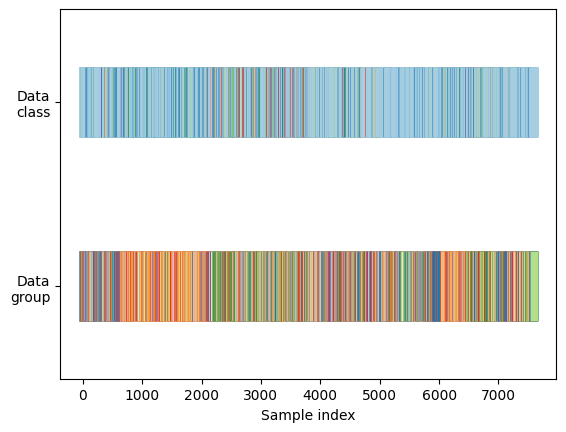

In [10]:
# Visualize data for CV
rng = np.random.RandomState(1338)
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm


def visualize_groups(classes, groups, name):
    fig, ax = plt.subplots()
    ax.scatter(
        range(len(groups)),
        [0.5] * len(groups),
        c=groups,
        marker="_",
        lw=50,
        cmap=cmap_data,
    )
    ax.scatter(
        range(len(groups)),
        [3.5] * len(groups),
        c=classes,
        marker="_",
        lw=50,
        cmap=cmap_data,
    )
    ax.set(
        ylim=[-1, 5],
        yticks=[0.5, 3.5],
        yticklabels=["Data\ngroup", "Data\nclass"],
        xlabel="Sample index",
    )
    return fig


data_vis = visualize_groups(y_train_new, groups, "no groups")

In [11]:
def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=5):
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
        )

    # Plot the data classes and groups at the end
    ax.scatter(
        range(len(X)), [ii + 1.5] * len(X), c=y, marker="_", lw=lw, cmap=cmap_data
    )

    ax.scatter(
        range(len(X)), [ii + 2.5] * len(X), c=group, marker="_", lw=lw, cmap=cmap_data
    )

    # Formatting
    yticklabels = list(range(n_splits)) + ["class", "group"]
    ax.set(
        yticks=np.arange(n_splits + 2) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits + 2.2, -0.2],
        xlim=[0, 100],
    )
    ax.set_title("{}".format(type(cv).__name__), fontsize=15)
    return ax

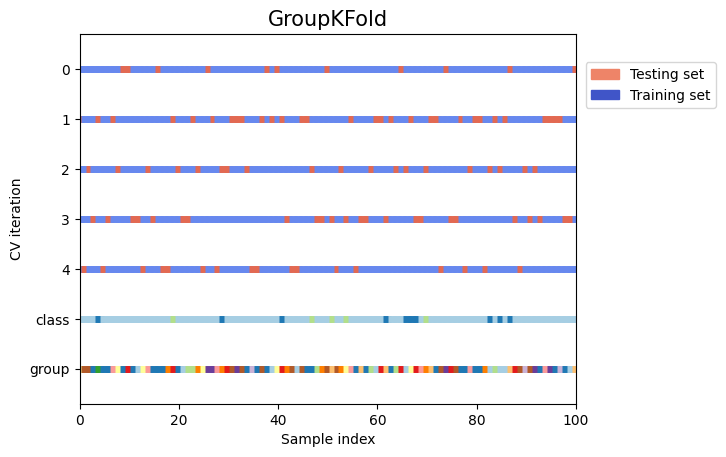

In [12]:
# Plotting CV

fig, ax = plt.subplots()
cv = GroupKFold(n_splits=5)
cv_plot = plot_cv_indices(gkf, df_train_new, y_train_new, groups, ax, 5)

ax.legend(
    [Patch(color=cmap_cv(0.8)), Patch(color=cmap_cv(0.02))],
    ["Testing set", "Training set"],
    loc=(1.02, 0.8),
)

# Models

## Basic

### Training

In [86]:
xgb.set_config(verbosity=1)

xgb_cv_model = XGBRegressor(learning_rate=0.05, max_depth=8,
                            subsample=0.8, colsample_bytree=0.5, min_child_weight=3, n_estimators=300)

scoring = {'r2': 'r2', 'rmse': 'neg_root_mean_squared_error'}

ti = time()

scores = cross_validate(xgb_cv_model, X_train_new, y_train_new, groups=groups,
                        verbose=0, scoring=scoring, cv=gkf, return_train_score=True, error_score='raise')

xgb_cv_model.fit(X_train_new, y_train_new, verbose=True)

dt = time() - ti

print(f'Finished fitting model, total time: {dt:0.2f} s')

print(scores.keys())

KeyboardInterrupt: 

### Evaluation

In [ ]:
# Print cross-validation scores
print("Cross-validation R-squared scores:", scores['test_r2'])
print("Mean R-squared score:", scores['test_r2'].mean())

print("Cross-validation RMSE scores:", -scores['test_rmse'])
print("Mean RMSE score:", -scores['test_rmse'].mean())

Cross-validation R-squared scores: [0.91213967 0.92692344 0.8550689  0.90127499 0.90810605]
Mean R-squared score: 0.9007026090246519
Cross-validation RMSE scores: [2.77522019 2.29616608 3.81113357 3.00640826 2.84718325]
Mean RMSE score: 2.9472222679300417


In [ ]:
y_pred = xgb_cv_model.predict(X_test)

# Calculate R-squared
r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2:.4f}")

# Calculate RMSE
rmse = root_mean_squared_error(y_test, y_pred)
print(f"Root Mean Squared Error: {rmse:.4f}")

R-squared: 0.8844
Root Mean Squared Error: 3.1022


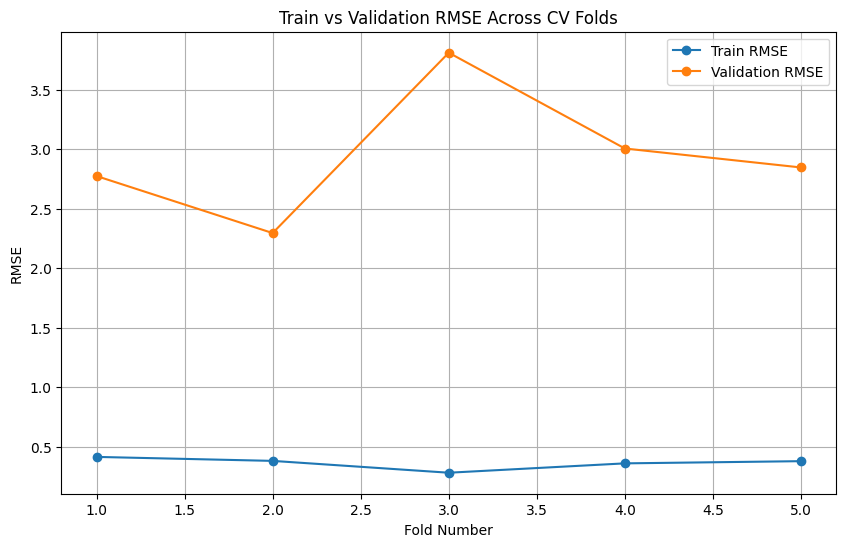

In [ ]:
# Extracting train and test RMSE scores
# Negative because sklearn returns the negative RMSE
train_rmse_scores = -scores['train_rmse']
test_rmse_scores = -scores['test_rmse']

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_rmse_scores) + 1),
         train_rmse_scores, 'o-', label='Train RMSE')
plt.plot(range(1, len(test_rmse_scores) + 1),
         test_rmse_scores, 'o-', label='Validation RMSE')

plt.title('Train vs Validation RMSE Across CV Folds')
plt.xlabel('Fold Number')
plt.ylabel('RMSE')
plt.legend()
plt.show()

### Feature Importance

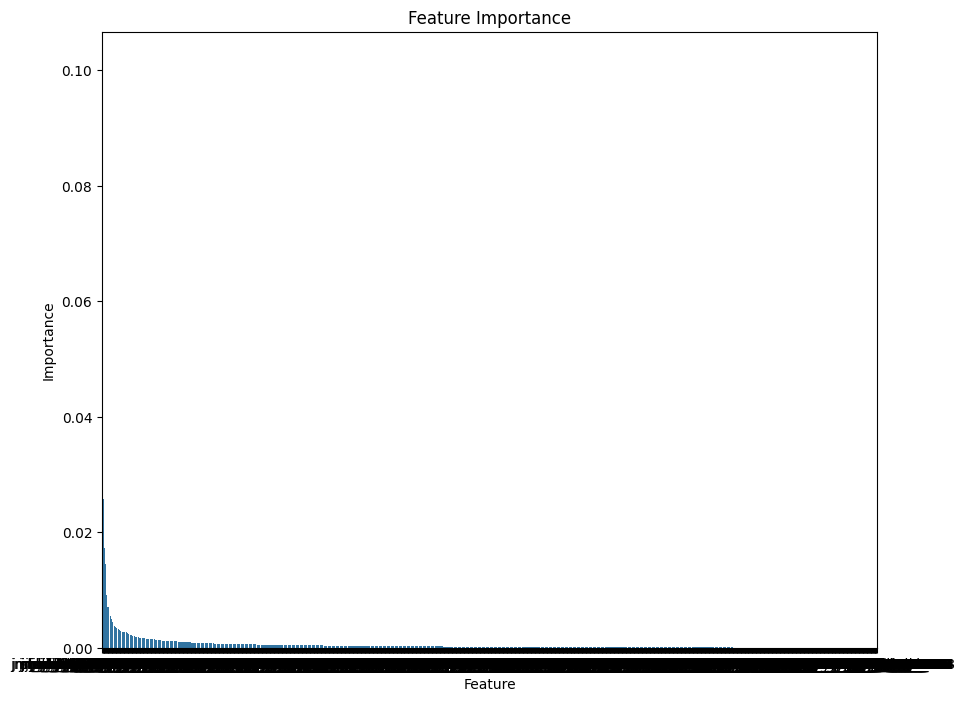

In [ ]:
# Get feature importance
importance = xgb_cv_model.feature_importances_

# Create a DataFrame to display the importance along with feature names
importance_df = pd.DataFrame({
    'Feature': columns,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

# Plotting feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x='Feature', y='Importance', data=importance_df)
plt.title('Feature Importance')
plt.show()

### Residual Analysis

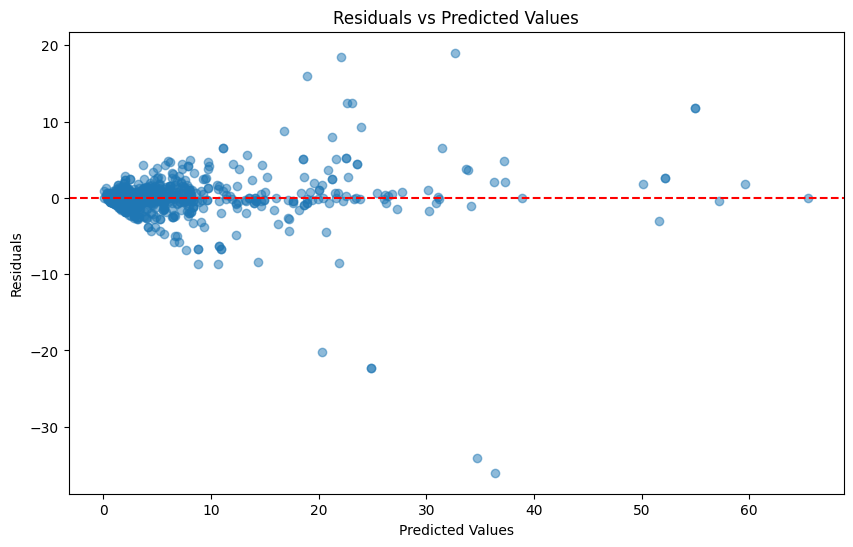

In [ ]:
# Calculate residuals
residuals = y_test - y_pred

# Plotting residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.show()

### Learning Curve Analysis

In [ ]:
# Generate learning curve data
train_sizes, train_scores, test_scores = learning_curve(
    XGBRegressor(learning_rate=0.05, max_depth=8,
                 subsample=0.8, colsample_bytree=0.5, min_child_weight=3, n_estimators=300),
    X_train_new, y_train_new, groups=groups, cv=gkf, scoring='neg_root_mean_squared_error', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calculate mean and std for plotting
train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plotting learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-',
         color="r", label="Training RMSE")
plt.plot(train_sizes, test_scores_mean, 'o-',
         color="g", label="Validation RMSE")

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")

plt.title('Learning Curves')
plt.xlabel('Training Examples')
plt.ylabel('RMSE')
plt.legend(loc="best")

plt.show()

KeyboardInterrupt: 

### SHAP interpretation

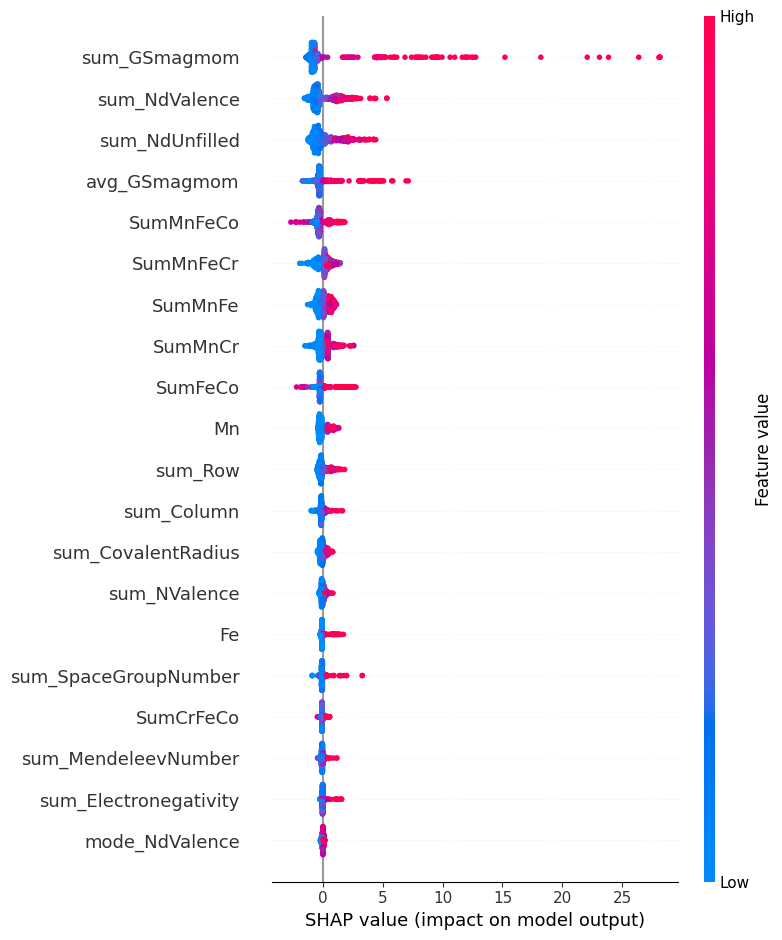

In [ ]:
# Initialize the explainer
explainer = shap.TreeExplainer(xgb_cv_model)

# Calculate SHAP values
shap_values = explainer.shap_values(X_test)

# Plotting summary plot
shap.summary_plot(shap_values, X_test, feature_names=columns)

In [ ]:
xgb_explainer = shap.TreeExplainer(xgb_cv_model, X_train_new)
data_dmatrix = xgb.DMatrix(data=X_train_new, label=y_train_new)
y_pred = xgb_cv_model.predict(X_train_new)
shap_explainer_values = xgb_explainer(X_train_new, y_pred)

100%|===================| 7574/7594 [01:49<00:00]        

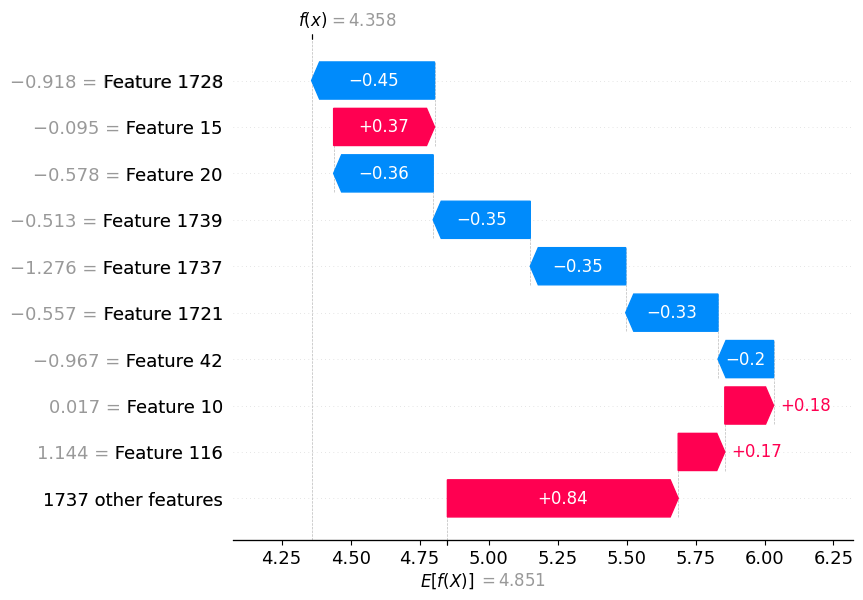

In [ ]:
shap.waterfall_plot(shap_explainer_values[0])

## Regularized Model

### Training

In [ ]:
xgb.set_config(verbosity=1)

xgb_cv_model_reg = XGBRegressor(learning_rate=0.1, max_depth=6,
                            subsample=0.8, colsample_bytree=1.0,
                            min_child_weight=5, reg_alpha=0.1, reg_lambda=0.1)

scoring = {'r2': 'r2', 'rmse': 'neg_root_mean_squared_error'}

ti = time()

scores_reg = cross_validate(xgb_cv_model_reg, X_train_new, y_train_new, groups=groups, verbose=0, scoring=scoring, cv=gkf, return_train_score=True, error_score='raise')

xgb_cv_model_reg.fit(X_train_new, y_train_new, verbose=True)

dt = time() - ti

print(f'Finished fitting model, total time: {dt:0.2f} s')

print(scores_reg.keys())

Finished fitting model, total time: 33.18 s
dict_keys(['fit_time', 'score_time', 'test_r2', 'train_r2', 'test_rmse', 'train_rmse'])


### Evaluation

In [ ]:
# Print cross-validation scores
print("Cross-validation R-squared scores:", scores_reg['test_r2'])
print("Mean R-squared score:", scores_reg['test_r2'].mean())

print("Cross-validation RMSE scores:", -scores_reg['test_rmse'])
print("Mean RMSE score:", -scores_reg['test_rmse'].mean())

Cross-validation R-squared scores: [0.89895689 0.91669343 0.84173689 0.90047934 0.90258743]
Mean R-squared score: 0.892090797817701
Cross-validation RMSE scores: [2.97614702 2.45162407 3.98256818 3.01849857 2.93142946]
Mean RMSE score: 3.072053460638245


In [ ]:
y_pred_reg = xgb_cv_model_reg.predict(X_test)

# Calculate R-squared
r2_reg = r2_score(y_test, y_pred_reg)
print(f"R-squared: {r2_reg:.4f}")

# Calculate RMSE
rmse_reg = mean_squared_error(y_test, y_pred_reg, squared=False)
print(f"Root Mean Squared Error: {rmse_reg:.4f}")

R-squared: 0.8636
Root Mean Squared Error: 3.3699


/Users/andrew/Desktop/School/Research/ChemML/env/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


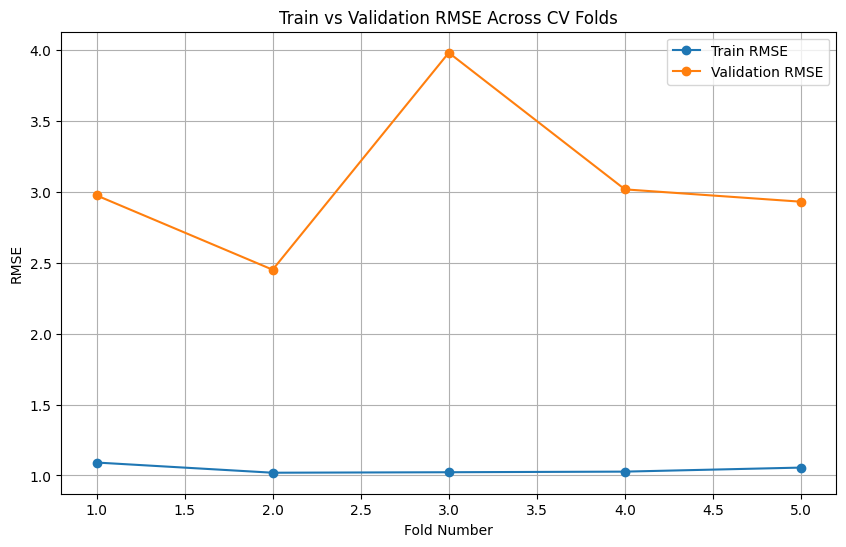

In [ ]:
# Extracting train and test RMSE scores
# Negative because sklearn returns the negative RMSE
train_rmse_scores_reg = -scores_reg['train_rmse']
test_rmse_scores_reg = -scores_reg['test_rmse']

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_rmse_scores_reg) + 1),
         train_rmse_scores_reg, 'o-', label='Train RMSE')
plt.plot(range(1, len(test_rmse_scores_reg) + 1),
         test_rmse_scores_reg, 'o-', label='Validation RMSE')

plt.title('Train vs Validation RMSE Across CV Folds')
plt.xlabel('Fold Number')
plt.ylabel('RMSE')
plt.legend()

plt.show()

### Feature Importance

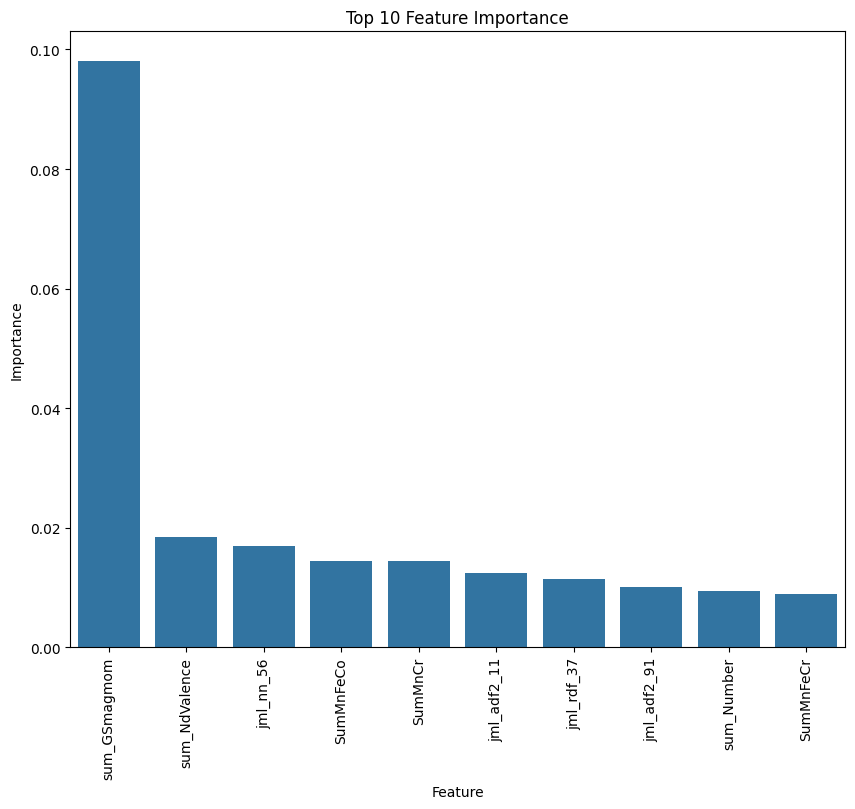

In [ ]:
importance_reg = xgb_cv_model_reg.feature_importances_

importance_df_reg = pd.DataFrame({
    'Feature': columns,
    'Importance': importance_reg
}).sort_values(by='Importance', ascending=False)

top_10_features = importance_df_reg.head(10)

plt.figure(figsize=(10, 8))
sns.barplot(x='Feature', y='Importance', data=top_10_features)
plt.title('Top 10 Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=90)
plt.show()

### Residual Analysis

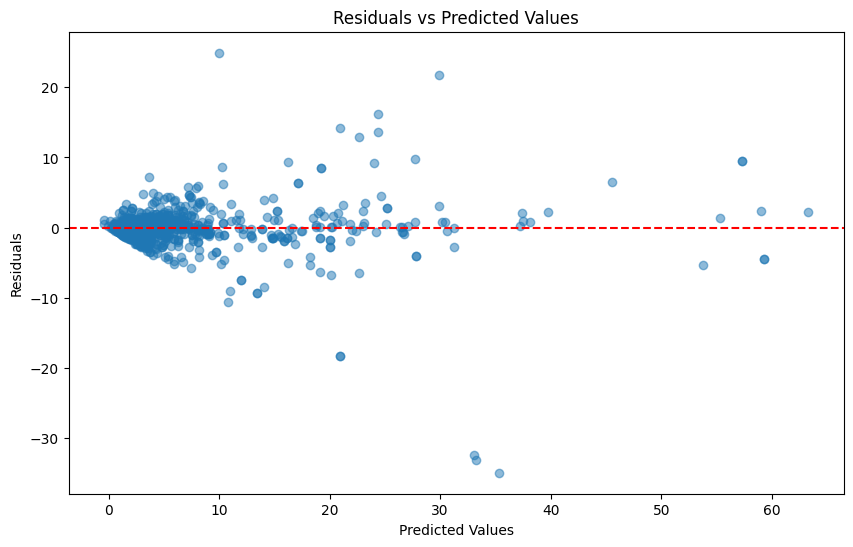

In [ ]:
# Calculate residuals
residuals_reg = y_test - y_pred_reg

# Plotting residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_reg, residuals_reg, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.show()

### Learning Curve Analysis

/Users/andrew/Desktop/School/Research/ChemML/env/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


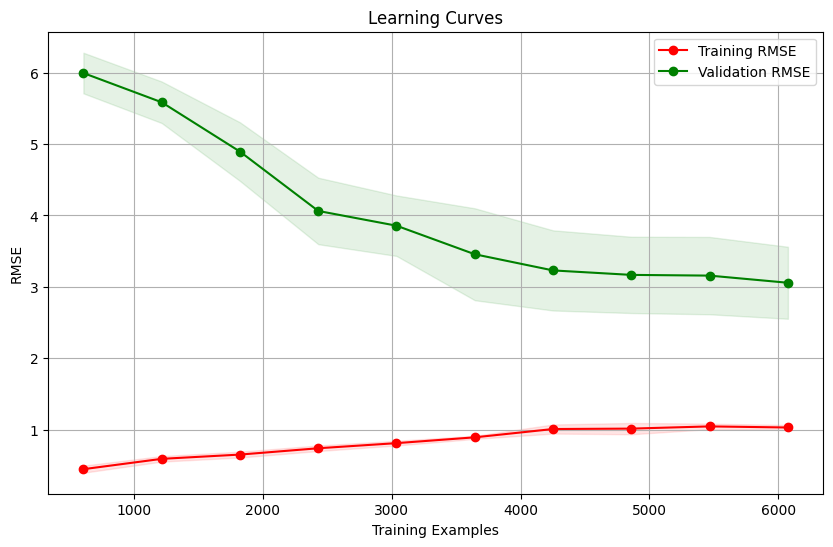

In [ ]:
# Generate learning curve data
train_sizes_reg, train_scores_reg, test_scores_reg = learning_curve(
    XGBRegressor(learning_rate=0.1, max_depth=6, subsample=0.8,
                 colsample_bytree=1.0, min_child_weight=5, reg_alpha=0.1, reg_lambda=0.1),
    X_train_new, y_train_new, groups=groups, cv=gkf, scoring='neg_root_mean_squared_error', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calculate mean and std for plotting
train_scores_mean_reg = -np.mean(train_scores_reg, axis=1)
train_scores_std_reg = np.std(train_scores_reg, axis=1)
test_scores_mean_reg = -np.mean(test_scores_reg, axis=1)
test_scores_std_reg = np.std(test_scores_reg, axis=1)

# Plotting learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes_reg, train_scores_mean_reg, 'o-',
         color="r", label="Training RMSE")
plt.plot(train_sizes_reg, test_scores_mean_reg, 'o-',
         color="g", label="Validation RMSE")

plt.fill_between(train_sizes_reg, train_scores_mean_reg - train_scores_std_reg,
                 train_scores_mean_reg + train_scores_std_reg, alpha=0.1, color="r")
plt.fill_between(train_sizes_reg, test_scores_mean_reg - test_scores_std_reg,
                 test_scores_mean_reg + test_scores_std_reg, alpha=0.1, color="g")

plt.title('Learning Curves')
plt.xlabel('Training Examples')
plt.ylabel('RMSE')
plt.legend(loc="best")

plt.show()

### SHAP interpretation

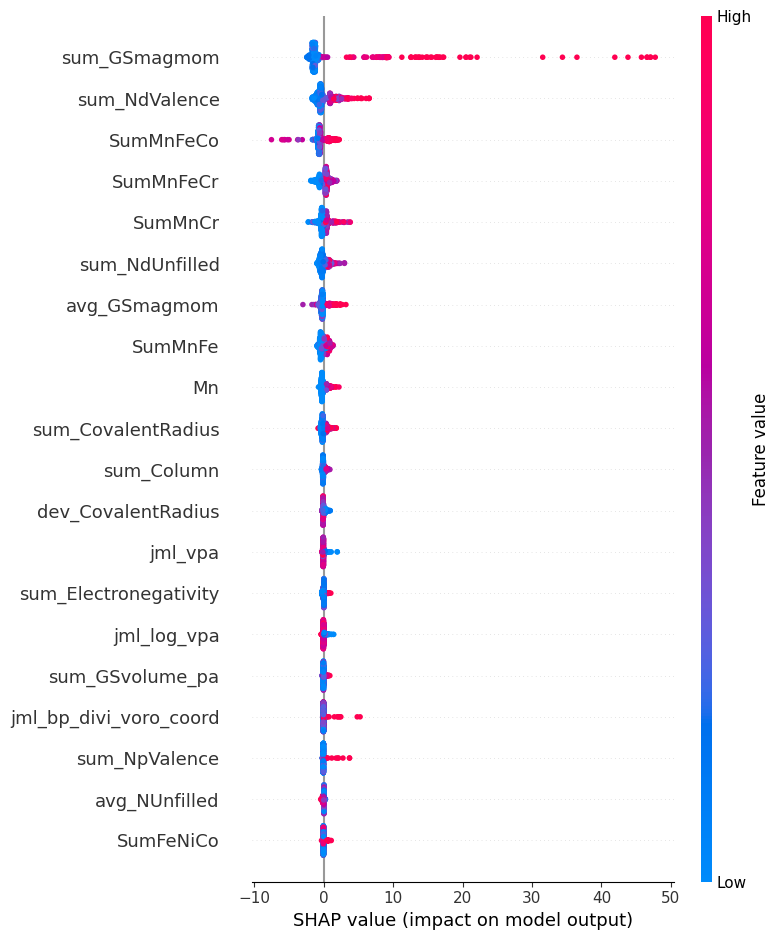

In [ ]:
# Initialize the explainer
explainer_reg = shap.TreeExplainer(xgb_cv_model_reg)

# Calculate SHAP values
shap_values_reg = explainer_reg.shap_values(X_test)

# Plotting summary plot
shap.summary_plot(shap_values_reg, X_test, feature_names=columns)

## Information

### Evaluation Explanations

Visualization of Losses: Helps to see how well the model is learning.

Feature Importance: Helps to understand which features are contributing the most to predictions.

Residual Analysis: Helps to analyze prediction errors.

Learning Curve: Helps to diagnose underfitting or overfitting.

Hyperparameter Tuning: Helps in finding the optimal set of hyperparameters.

SHAP Values: Provides model interpretability.

## Hyperparameter Tuning

### No Regularization

In [ ]:
# Define the parameter grid
param_dist = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 6, 8, 10],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.3, 0.5, 0.8, 1.0],
    'min_child_weight': [1, 3, 5, 7],
    'n_estimators': [100, 300, 500, 1000]
}

# RandomizedSearchCV with 5-fold cross-validation
random_search = RandomizedSearchCV(xgb_cv_model, param_distributions=param_dist,
                                   scoring='neg_root_mean_squared_error',
                                   n_iter=50, cv=5, verbose=1, random_state=42, n_jobs=-1)

# Fit model
random_search.fit(X_train_new, y_train_new)

# Print best parameters and score
print(f"Best Parameters: {random_search.best_params_}")
print(f"Best RMSE: {-random_search.best_score_}")

# Output
# Best Parameters: {'subsample': 0.8, 'n_estimators': 300, 'min_child_weight': 3, 'max_depth': 8, 'learning_rate': 0.05, 'colsample_bytree': 0.5}
# Best RMSE: 3.1402698241933984

NameError: name 'RandomizedSearchCV' is not defined

### Regularization

In [ ]:
# Define the parameter grid
param_dist_reg = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 6, 8, 10],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.3, 0.5, 0.8, 1.0],
    'min_child_weight': [1, 3, 5, 7],
    'n_estimators': [100, 300, 500, 1000],
    'reg_alpha': [0, 0.01, 0.05, 0.1, 0.2],
    'reg_lambda': [0, 0.01, 0.05, 0.1, 0.2],
}

# RandomizedSearchCV with 5-fold cross-validation
random_search_reg = RandomizedSearchCV(xgb_cv_model_reg, param_distributions=param_dist_reg,scoring='neg_root_mean_squared_error',n_iter=50, cv=5, verbose=1, random_state=42, n_jobs=-1)

# Fit model
random_search_reg.fit(X_train_new, y_train_new)

# Print best parameters and score
print(f"Best Parameters: {random_search_reg.best_params_}")
print(f"Best RMSE: {-random_search_reg.best_score_}")

# Output
#{'subsample': 0.6, 'reg_lambda': 0.05, 'reg_alpha': 0.05, 'n_estimators': 500,'min_child_weight': 3, 'max_depth': 6, 'learning_rate': 0.05, 'colsample_bytree': 0.8}

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Users/andrew/Desktop/School/Research/ChemML/env/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Parameters: {'subsample': 0.6, 'reg_lambda': 0.05, 'reg_alpha': 0.05, 'n_estimators': 500, 'min_child_weight': 3, 'max_depth': 6, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
Best RMSE: 3.1480333359440555


## Best Model

In [13]:
xgb.set_config(verbosity=1)

best_model = XGBRegressor(reg_alpha=0.05, reg_lambda=0.05, learning_rate=0.05, max_depth=6,subsample=0.6, colsample_bytree=0.8, min_child_weight=3, n_estimators=500)

scoring = {'r2': 'r2', 'rmse': 'neg_root_mean_squared_error'}

ti = time()

scores = cross_validate(best_model, X_train_new, y_train_new, groups=groups,
                        verbose=0, scoring=scoring, cv=gkf, return_train_score=True, error_score='raise')

best_model.fit(X_train_new, y_train_new, verbose=True)

dt = time() - ti

print(f'Finished fitting model, total time: {dt:0.2f} s')

print(scores.keys())

Finished fitting model, total time: 157.38 s
dict_keys(['fit_time', 'score_time', 'test_r2', 'train_r2', 'test_rmse', 'train_rmse'])


In [14]:
# Print cross-validation scores
print("Cross-validation R-squared scores:", scores['test_r2'])
print("Mean R-squared score:", scores['test_r2'].mean())

print("Cross-validation RMSE scores:", -scores['test_rmse'])
print("Mean RMSE score:", -scores['test_rmse'].mean())

Cross-validation R-squared scores: [0.91524753 0.9248203  0.86068156 0.89768672 0.91272385]
Mean R-squared score: 0.902231992828502
Cross-validation RMSE scores: [2.72569465 2.32897345 3.73660918 3.06055622 2.77472374]
Mean RMSE score: 2.9253114477422413


In [38]:
y_pred = best_model.predict(X_test)

# Calculate R-squared
r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2:.4f}")

# Calculate RMSE
rmse = root_mean_squared_error(y_test, y_pred)
print(f"Root Mean Squared Error: {rmse:.4f}")

R-squared: 0.8737
Root Mean Squared Error: 3.2419


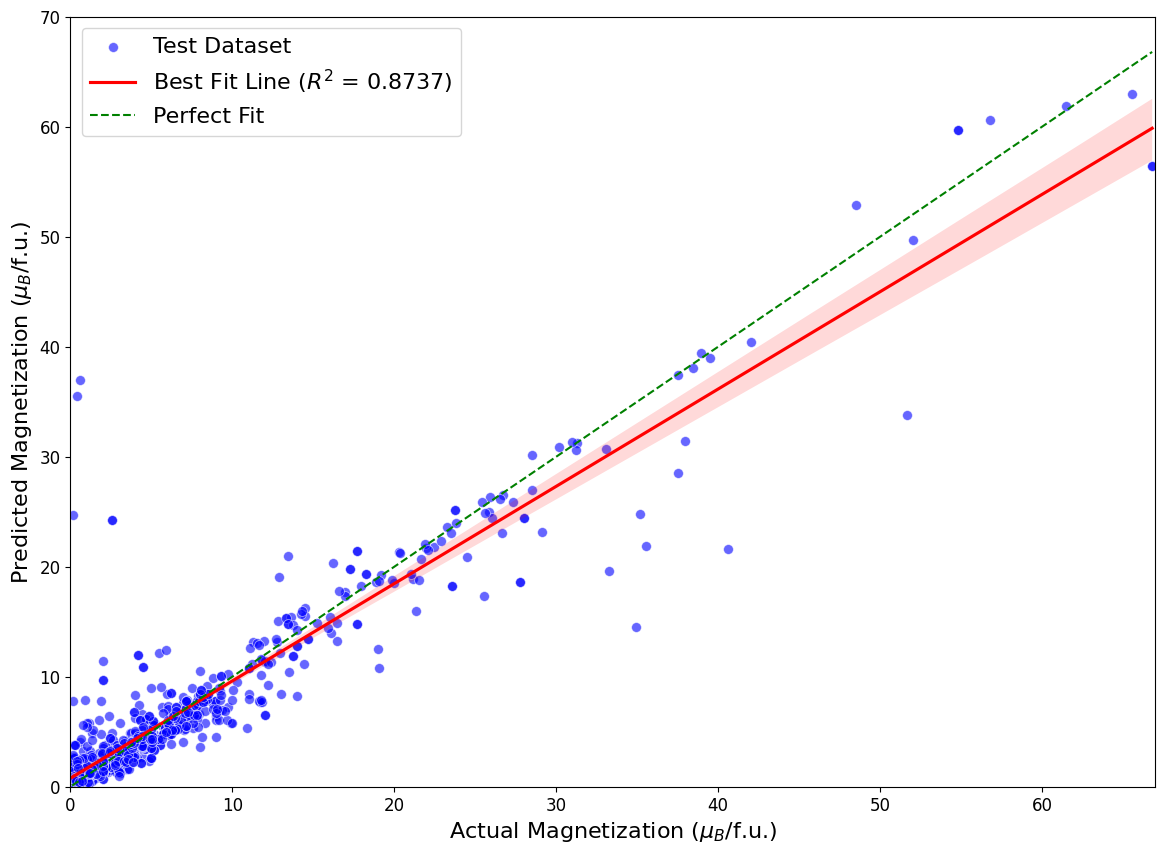

In [16]:
plt.figure(figsize=(14, 10))

r2 = r2_score(y_test, y_pred)

plt.rc('font', size=MEDIUM_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)

sns.scatterplot(x=y_test, y=y_pred, color='blue',
                alpha=0.6, s=50, label='Test Dataset')

sns.regplot(x=y_test, y=y_pred, scatter=False,
            color='red', label=f'Best Fit Line ($R^2$ = {round(r2, 4)})')

plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)],
         color='green', linestyle='--', label='Perfect Fit')

plt.ylabel('Predicted Magnetization ($\u03bc_B$/f.u.)')
plt.xlabel('Actual Magnetization ($\u03bc_B$/f.u.)')
plt.xlim([0, 67])
plt.ylim([0, 70])
plt.legend()
plt.show()

## Testing on Real Data

In [17]:
df_lit = pd.read_csv(DATA_PATH + "/test/real_data.csv")
df_truth = pd.read_csv(DATA_PATH + "/test/real_results.csv")

In [18]:
df_lit = df_lit.rename(columns=rename_dict)

In [19]:
X_lit_unscaled, y_lit, formulae_pred, skipped_pred = composition.generate_features(df_lit, elem_prop='magpie', drop_duplicates=False, extend_features=True, sum_feat=True)

Processing Input Data: 100%|██████████| 19/19 [00:00<00:00, 42232.00it/s]


	Featurizing Compositions...


Assigning Features...: 100%|██████████| 19/19 [00:00<00:00, 30255.04it/s]

	Creating Pandas Objects...


In [20]:
X_lit = scaler.transform(X_lit_unscaled)

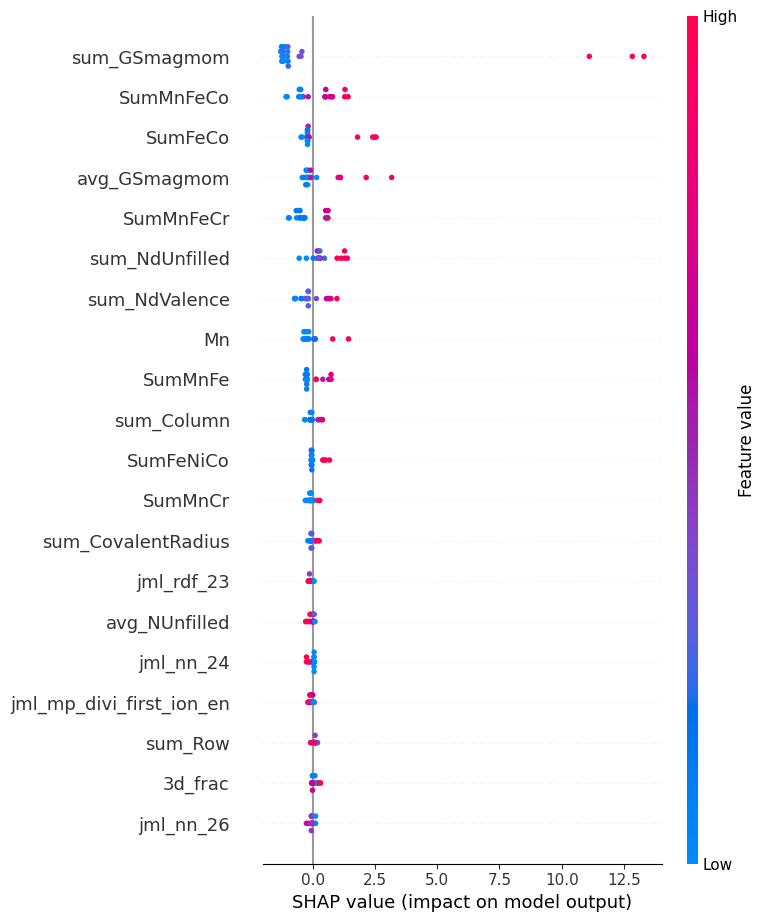

In [21]:
import shap

# Create the SHAP TreeExplainer using your best model
xgb_explainer = shap.TreeExplainer(best_model)

# Make predictions using your dataset
y_pred = best_model.predict(X_lit)

# Generate SHAP values for your dataset
shap_values = xgb_explainer(X_lit)

# Add feature names to the SHAP values
shap_values.feature_names = X_lit_unscaled.columns

# Visualize the SHAP summary plot
shap.summary_plot(shap_values.values, X_lit, feature_names=columns)

In [22]:
xgb_explainer = shap.TreeExplainer(
    best_model, X_train_new, feature_names=X_lit_unscaled.columns)
data_dmatrix = xgb.DMatrix(data=X_train_new, label=y_train_new)
y_pred = best_model.predict(X_lit)
shap_explainer_values = xgb_explainer(X_lit, y_pred)

sum_GSmagmom
formula                                         Hf2MnIr5B2
total_magnetization_normalized_formula_units          3.83
Citation                                               NaN
volume                                          218.927786
nelements                                                4
nsites                                                  20
crystal_system                                  tetragonal
number                                                 127
symbol                                              P4/mbm
point_group                                          4/mbm
Name: 0, dtype: object


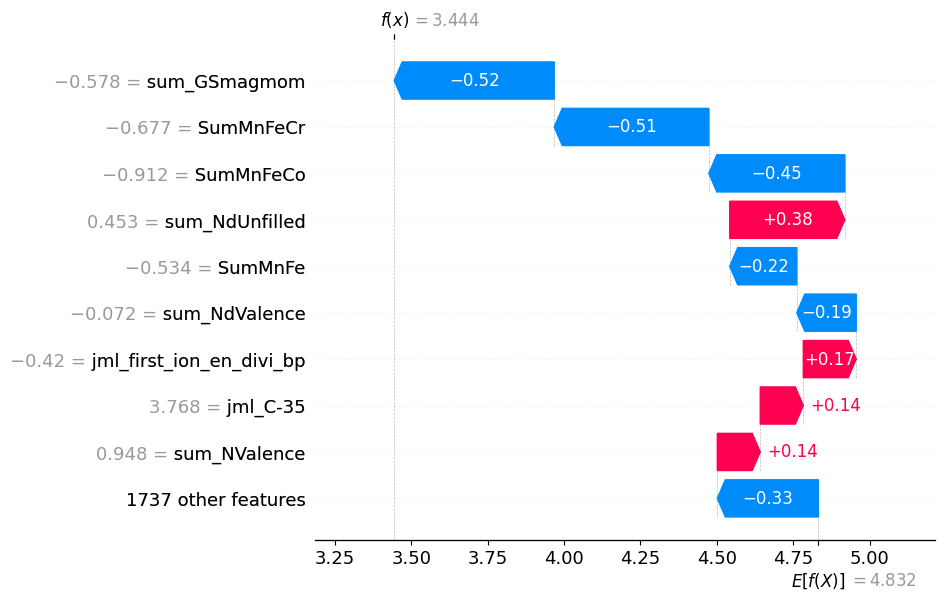

In [23]:
i = 0
print(X_lit_unscaled.columns[20])
print(df_truth.iloc[i])
waterfall = shap.waterfall_plot(shap_explainer_values[i], show=False)
plt.ylabel("")
plt.show()

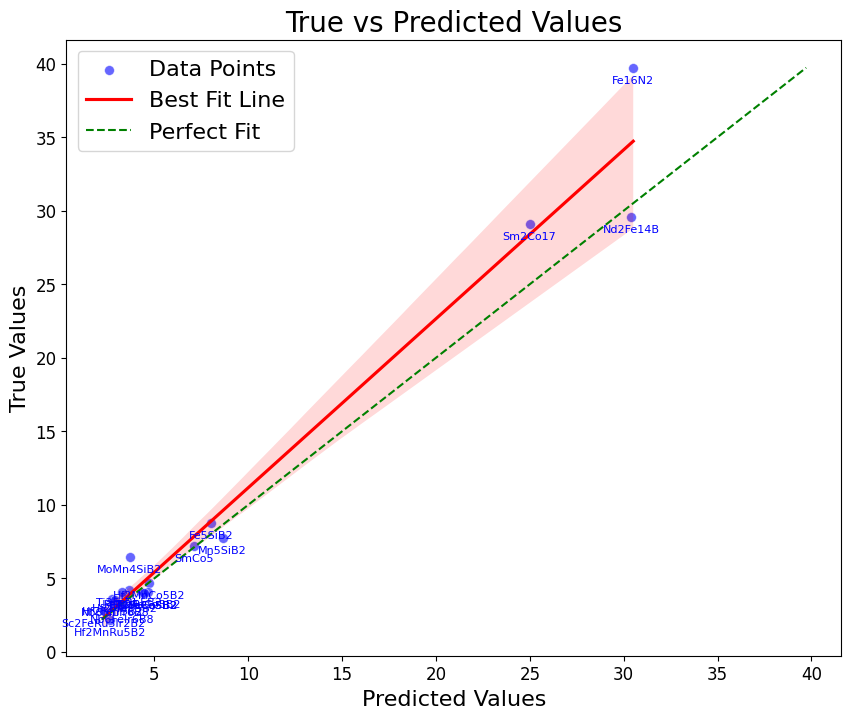

In [24]:
y_true = df_truth.total_magnetization_normalized_formula_units
y_true_formulas = df_truth.formula

plt.figure(figsize=(10, 8))

sns.scatterplot(x=y_pred, y=y_true, color='blue',
                alpha=0.6, s=50, label='Data Points')

for pred, true, formula in zip(y_pred, y_true, y_true_formulas):
    plt.text(pred, true - 0.5, formula, fontsize=8,
             ha='center', va='top', color='blue')

sns.regplot(x=y_pred, y=y_true, scatter=False,
            color='red', label='Best Fit Line')

plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)],
         color='green', linestyle='--', label='Perfect Fit')

plt.title('True vs Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.legend()

plt.show()

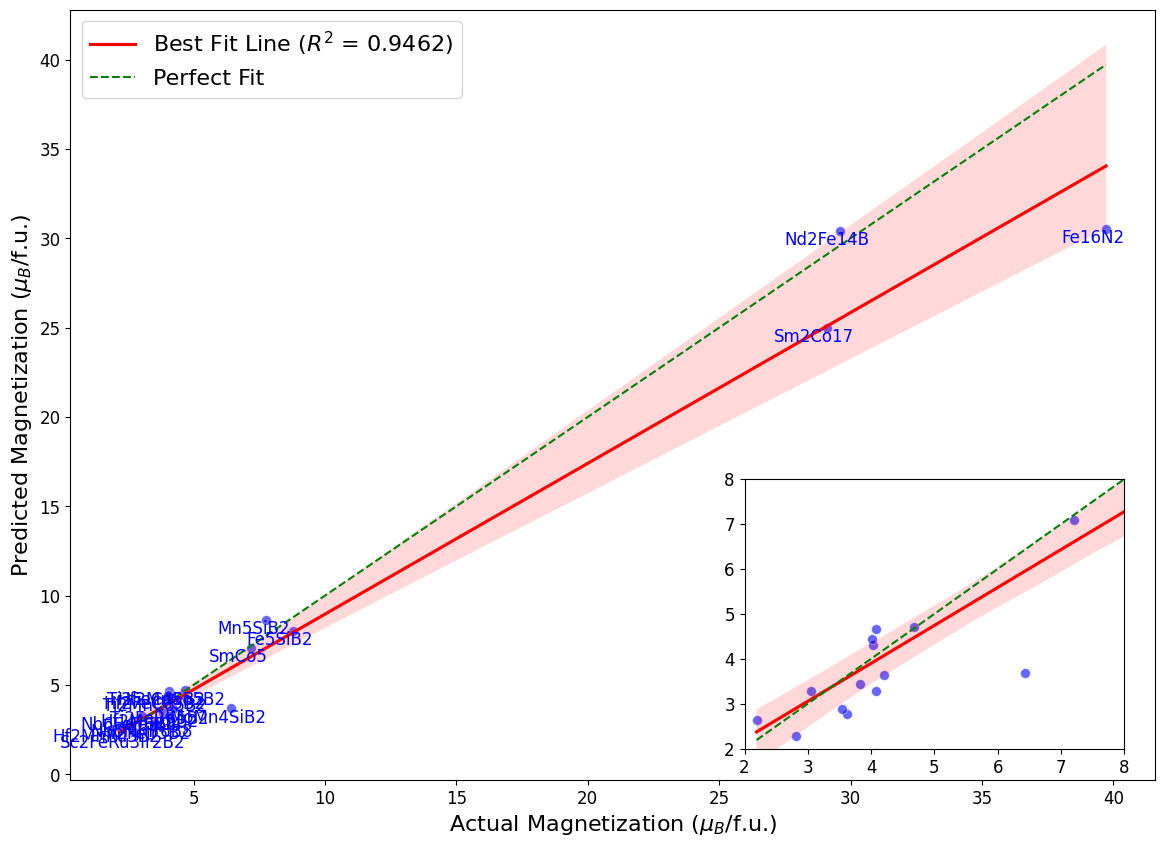

In [25]:
plt.figure(figsize=(14, 10))

r2 = r2_score(y_true, y_pred)

plt.rc('font', size=MEDIUM_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)

sns.scatterplot(x=y_true, y=y_pred, color='blue',
                alpha=0.6, s=50)

for pred, true, formula in zip(y_pred, y_true, y_true_formulas):
    plt.text(true - 0.5, pred, formula, fontsize=12,
             ha='center', va='top', color='blue')

sns.regplot(x=y_true, y=y_pred, scatter=False,
            color='red', label=f'Best Fit Line ($R^2$ = {round(r2, 4)})')

plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)],
         color='green', linestyle='--', label='Perfect Fit')

plt.ylabel('Predicted Magnetization ($\u03bc_B$/f.u.)')
plt.xlabel('Actual Magnetization ($\u03bc_B$/f.u.)')
plt.legend()

inset_ax = inset_axes(plt.gca(), width="35%", height="35%", loc='lower right', borderpad=1.4)

x_min, x_max = min(y_pred) - 0.1, max(y_pred) * 0.2
y_min, y_max = min(y_true) - 0.1, max(y_true) * 0.2

sns.scatterplot(x=y_true, y=y_pred, color='blue', alpha=0.6, s=50, ax=inset_ax)

sns.regplot(x=y_true, y=y_pred, scatter=False, color='red', ax=inset_ax)

plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)],
         color='green', linestyle='--', label='Perfect Fit')

inset_ax.set_ylim(2, 8)
inset_ax.set_xlim(2, 8)
inset_ax.set_xlabel(" ")

plt.show()

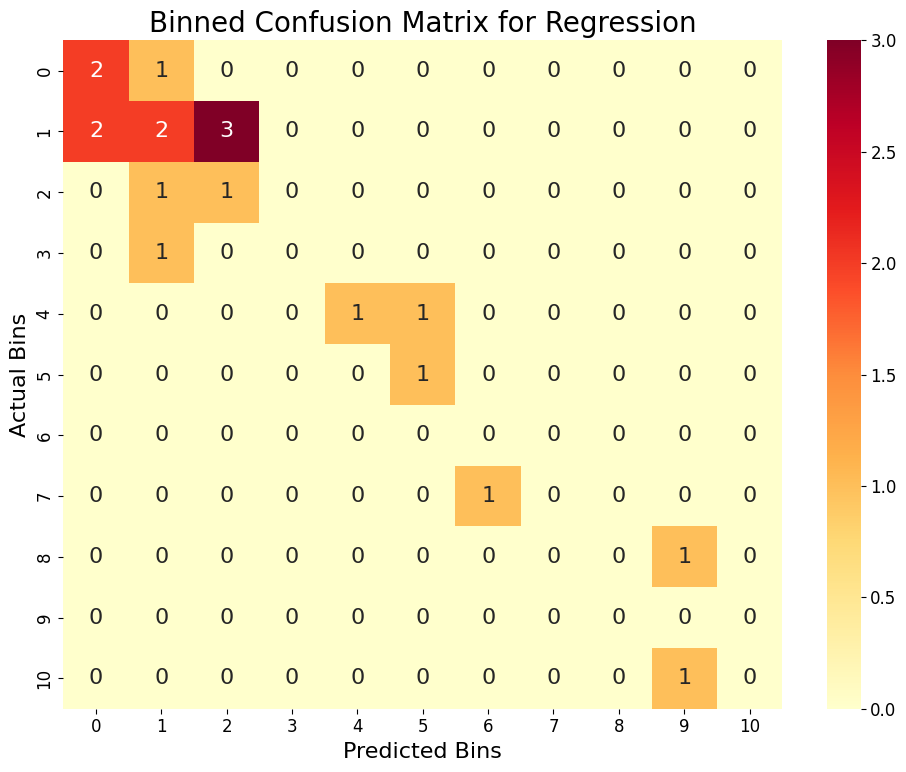

In [ ]:
plt.figure(figsize=(10, 8))
    
bins = np.linspace(min(min(y_true), min(y_pred)), 
                    max(max(y_true), max(y_pred)), 
                    40)

y_true_binned = np.digitize(y_true, bins) - 1
y_pred_binned = np.digitize(y_pred, bins) - 1

cm = confusion_matrix(y_true_binned, y_pred_binned)

sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrRd')
plt.title('Binned Confusion Matrix for Regression')
plt.xlabel('Predicted Bins')
plt.ylabel('Actual Bins')
plt.tight_layout()
plt.show()

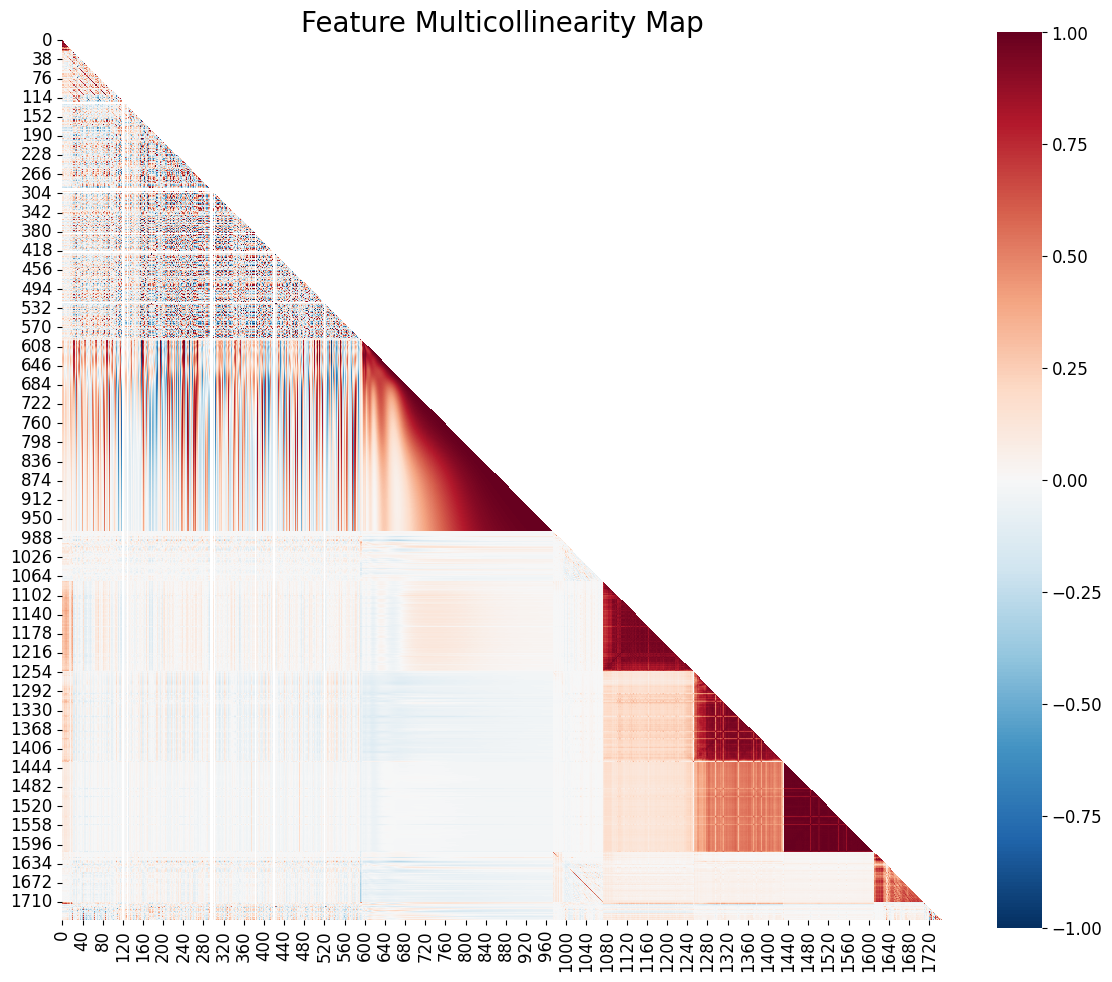

In [27]:
plt.figure(figsize=(12, 10))
    
# Calculate correlation matrix
corr_matrix = pd.DataFrame(X_train_new).corr()

# Create heatmap
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, cmap='RdBu_r', center=0,
            annot=False, square=True, vmin=-1, vmax=1)

plt.title('Feature Multicollinearity Map')
plt.tight_layout()
plt.show()

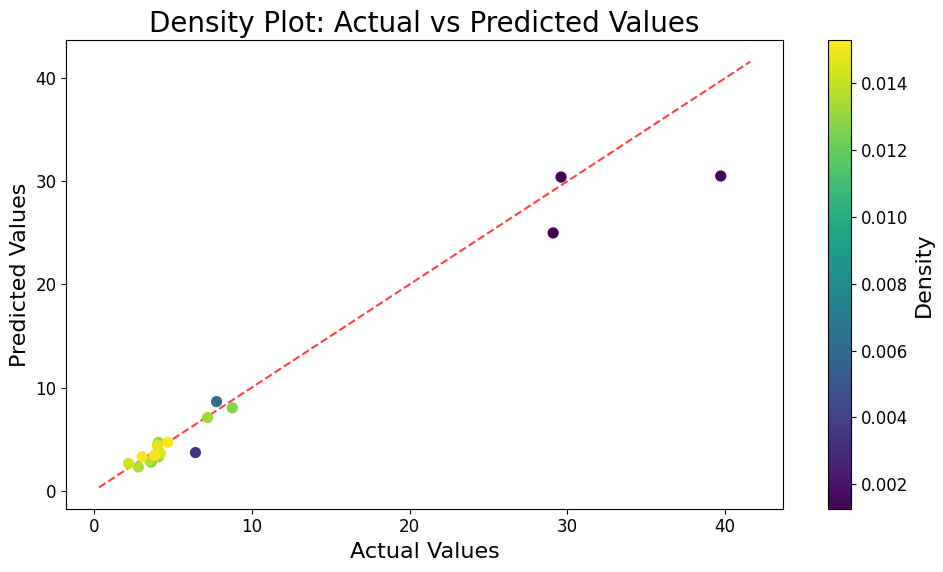

In [28]:
plt.figure(figsize=(10, 6))
    
# Calculate the point density
xy = np.vstack([y_true, y_pred])
z = gaussian_kde(xy)(xy)

# Sort the points by density
idx = z.argsort()
y_true, y_pred, z = y_true[idx], y_pred[idx], z[idx]

# Create scatter plot
plt.scatter(y_true, y_pred, c=z, s=50)

# Add diagonal line
lims = [
    np.min([plt.xlim()[0], plt.ylim()[0]]),
    np.max([plt.xlim()[1], plt.ylim()[1]]),
]
plt.plot(lims, lims, 'r--', alpha=0.75, zorder=0)

plt.colorbar(label='Density')
plt.title('Density Plot: Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.tight_layout()
plt.show()

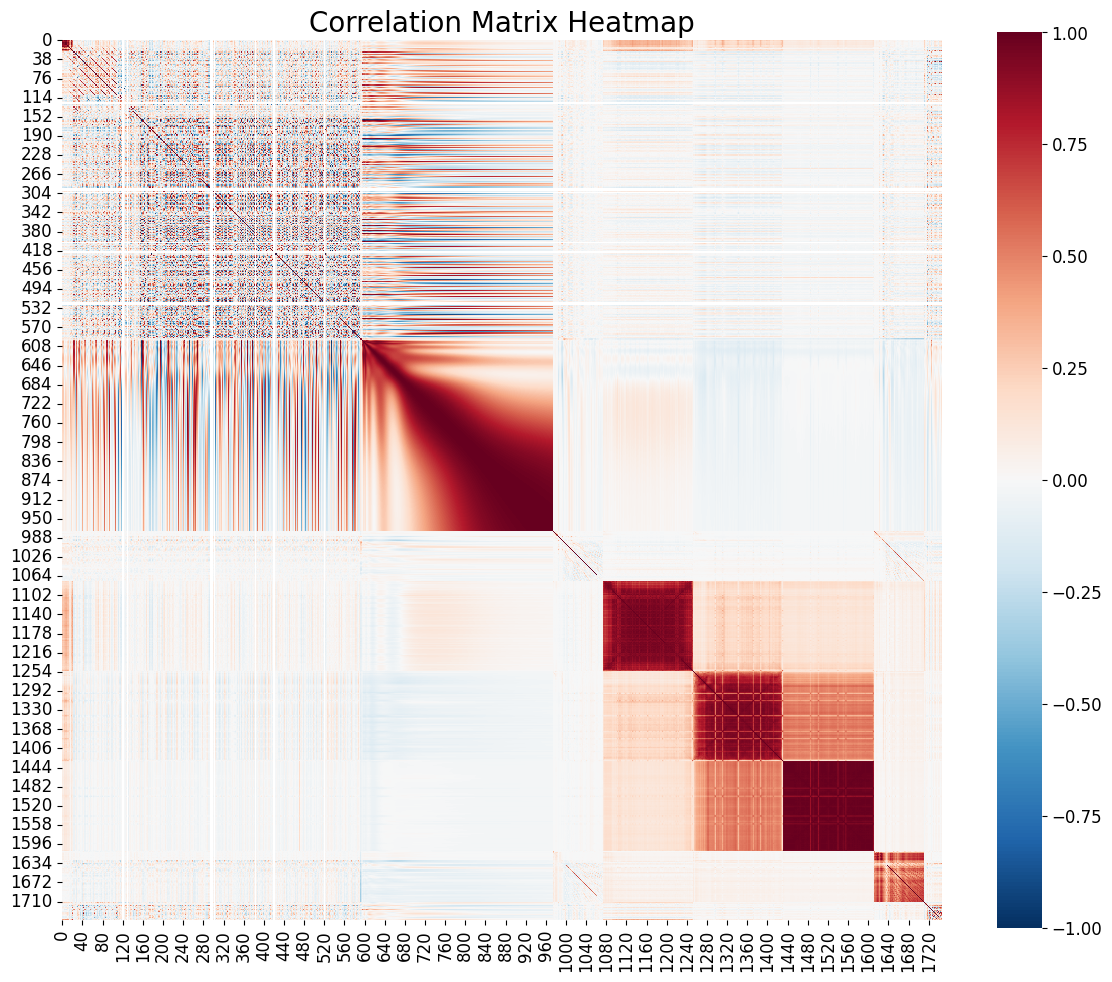

In [29]:
plt.figure(figsize=(12, 10))
    
data = pd.DataFrame(X_train_new)
data['target'] = y_train_new.reset_index(drop=True)

corr_matrix = data.corr()

sns.heatmap(corr_matrix, cmap='RdBu_r', center=0,
            annot=False, square=True)
plt.title('Correlation Matrix Heatmap')
plt.tight_layout()
plt.show()